### Smooth transition between analytic functions

The idea is to create a smooth transition in a place where a function is discontinuous.

This way to create smoothness is useful because it doesn't have to evaluate the original piecewise functions outside their original domains.

The original discontinuity usually happens because a function is already defined like this:

$$
  f(x) = \left\{
     \begin{array}{r}
       f_{left}(x)  &: x < x_{threshold}\\
       f_{right}(x)  &: x \geq x_{threshold}\\
     \end{array}
   \right.
$$

For example:

In [1]:
import sympy
from sympy import Piecewise
import numpy as np


# For example:
x_ = sympy.symbols('x', real=True)

f_left_ = x_**1.2
f_right_ = 10.0 / x_**0.2

x_threshold = 10.0 ** (5 / 7)

f_ = Piecewise(
    (f_left_, x_ < x_threshold),
    (f_right_, True)
)

f = sympy.lambdify(x_, f_)

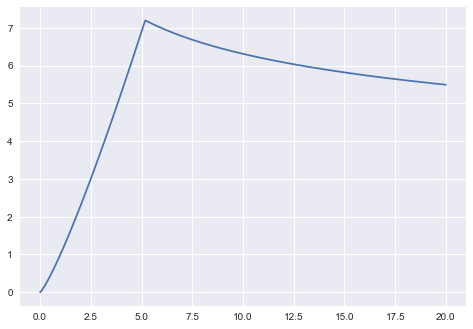

In [2]:
import seaborn
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

x = np.linspace(0.001, 20, 1000)
y = f(x)

plt.plot(x, y)
plt.show()

What we want is $C^1$ continuity, i.e., first-derivatives are continuous, without needing values of `f_left` and `f_right` outside where they are defined.

To accomplish this, we'll join the second derivatives of both functions by a line, around a region $[x_0, x_1]$ that contains the threshold:

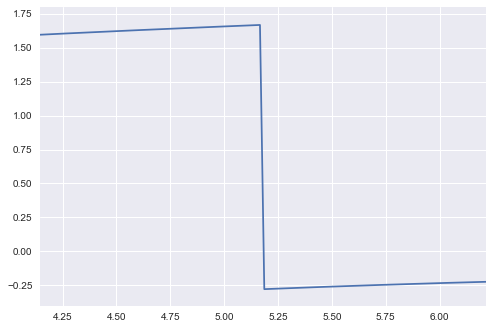

In [3]:
d_dx_f_left_ = sympy.diff(f_left_, x_, 1)
d_dx_f_right_ = sympy.diff(f_right_, x_, 1)

d_dx_f_ = Piecewise(
    (d_dx_f_left_, x_ < x_threshold),
    (d_dx_f_right_, True)
)

d_dx_f = sympy.lambdify(x_, d_dx_f_)


d_dx_f_left = sympy.lambdify(x_, d_dx_f_left_)
d_dx_f_right = sympy.lambdify(x_, d_dx_f_right_)

plt.plot(x, d_dx_f(x))
plt.xlim((x_threshold * 0.8, x_threshold * 1.2))
plt.ylim((-0.4, 1.8))
plt.show()

The derivative is indeed very discontinuous! Let's fix this!

They do not need to be symmetric around the threshold

In [4]:
x_0 = x_threshold * 0.8
x_1 = x_threshold * 1.2

d_dx_at_x_0 = d_dx_f_left_.evalf(subs={x_: x_0})
d_dx_at_x_1 = d_dx_f_right_.evalf(subs={x_: x_1})

d_dx_f_center_ = d_dx_at_x_0 + ((x_ - x_0) / (x_1 - x_0)) * (d_dx_at_x_1 - d_dx_at_x_0)

d_dx_f_smooth_ = Piecewise(
    (d_dx_f_left_, x_ < x_0),
    (d_dx_f_center_, x_ < x_1),
    (d_dx_f_right_, True)
)

d_dx_f_smooth = sympy.lambdify(x_, d_dx_f_smooth_)


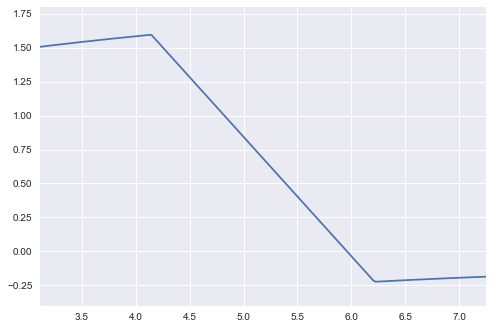

In [5]:
plt.plot(x, d_dx_f_smooth(x))
plt.xlim((x_threshold * 0.6, x_threshold * 1.4))
plt.ylim((-0.4, 1.8))
plt.show()

So now we just have to integrate `d_dx_f_center` and adjust it's integral constant to create a better piecewise `f_smooth`



In [6]:
f_center_ = sympy.integrate(d_dx_f_center_, x_)

f_left = sympy.lambdify(x_, f_left_)
f_center = sympy.lambdify(x_, f_center_)

# f_center(x0) == f_left(x0)
f_center_ = f_center_ + (f_left(x_0) - f_center(x_0))

f_smooth_ = Piecewise(
    (f_left_, x_ < x_0),
    (f_center_, x_ < x_1),
    (f_right_, True)
)

f_smooth = sympy.lambdify(x_, f_smooth_)

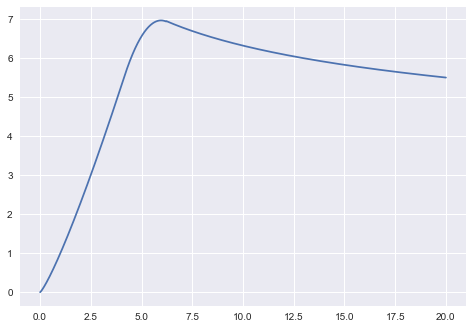

In [7]:
plt.plot(x, f_smooth(x))
plt.show()

Much better!
Now let's generalize a way to create `f_center`:

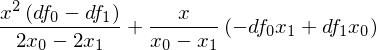

In [8]:
sympy.init_printing()

x_0_, x_1_, f_0_ = sympy.symbols('x_0,x_1,f_{left}(x_0)', real=True)

# df_0 is f_left'(x_0)
# df_1 is f_right'(x_1)

df_0_, df_1_ = sympy.symbols('df_0,df_1', real=True)

a = (x_ - x_0_) / (x_1_ - x_0_)

# d_dx_f_center_ = d_dx_at_x_0 + a * (d_dx_at_x_1 - d_dx_at_x_0)
d_dx_f_center_ = (1 - a) * df_0_ + a * df_1_
f_center_ = sympy.integrate(d_dx_f_center_, x_)

# f_center_ = f_center_ + f_0_ - f_center_.subs(x_, x_0_)

f_center_

In [9]:
# Simplifying f_center to be an equation like x * (a*x + b) + c:

def get_f_center_coefficients(x0, x1, f_left, df_left, df_right):
    dx = x1 - x0
    df0 = df_left(x0)
    df1 = df_right(x1)
    a = 0.5 * (df1 - df0) / dx
    b = (df0*x1 - df1*x0) / dx
    c = f_left(x0) - (x0 * (a*x0 + b))
    return a, b, c

x_0 = x_threshold * 0.8
x_1 = x_threshold * 1.2

# So, for example:
a, b, c = get_f_center_coefficients(
    x_0,
    x_1,
    f_left=lambda x: x**1.2,
    df_left=lambda x: 1.2 * x**0.2,
    df_right=lambda x: -2.0*x**-1.2,
)

print (a, b, c)

-0.4387286573389664 5.230431342173345 -8.63388046349694


In [10]:
def f_smooth(x):
    return np.piecewise(x, [x < x_0, (x_0 <= x) & (x <= x_1), x > x_1], [
        lambda x: x**1.2,
        lambda x: x * (-0.4387286573389664 * x + 5.230431342173345) - 8.63388046349694,
        lambda x: 10.0 / x**0.2,
    ])


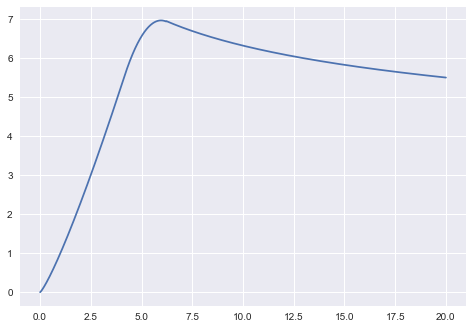

In [11]:
plt.plot(x, f_smooth(x))
plt.show()